# Yoga Pose Classification

This notebook implements a binary classification model to distinguish between two yoga poses:
- Downdog
- Goddess

We'll use a CNN-based approach with transfer learning to achieve high accuracy.

This notebook implements three different CNN architectures for yoga pose classification:
1. Simple CNN from scratch
2. Inception-style CNN from scratch
3. Transfer Learning with MobileNetV2

## Business Understanding

This project focuses on developing a deep learning solution for classifying yoga poses, specifically "downdog" and "goddess" poses. The goal is to create an accurate and robust classification system

In [ ]:
# Import required libraries
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Define hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
MAX_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 10
LEARNING_RATE = 0.001

# Augmentation parameters
ROTATION_RANGE = 30
SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2

## Data Requirements & Data Collection

The dataset consists of two yoga poses:
1. Downdog (Adho Mukha Svanasana)
2. Goddess Pose (Utkata Konasana)

Data is organized in the following structure:
- DATASET/
  - TRAIN/
    - downdog/
    - goddess/
  - TEST/
    - downdog/
    - goddess/

In [ ]:
!git clone https://github.com/tajoutihamza/deep-learning-YOGA.git
# Define source and destination paths
source_dir = "/content/deep-learning-YOGA/DATASET"  # Replace with the actual path
destination_dir = "/content"  # Replace with your desired destination

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Move the DATASET folder and its contents
try:
    shutil.move(source_dir, destination_dir)
    print(f"Successfully moved '{source_dir}' to '{destination_dir}'")
except FileNotFoundError:
    print(f"Error: Source directory '{source_dir}' not found.")
except shutil.Error as e:
    print(f"Error moving directory: {e}")


# Verify the move (optional)
if os.path.exists(destination_dir):
    print(f"Directory '{destination_dir}' now exists.")
    !ls /content/DATASET

fatal: destination path 'deep-learning-YOGA' already exists and is not an empty directory.
Error moving directory: Destination path '/content/DATASET' already exists
Directory '/content' now exists.
TEST  TRAIN


In [ ]:
# Set up data paths
TRAIN_DIR = 'DATASET/TRAIN'
TEST_DIR = 'DATASET/TEST'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=ROTATION_RANGE,
    width_shift_range=SHIFT_RANGE,
    height_shift_range=SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 322 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


## Data Visualization

Let's visualize some sample images from our dataset, both original and augmented:

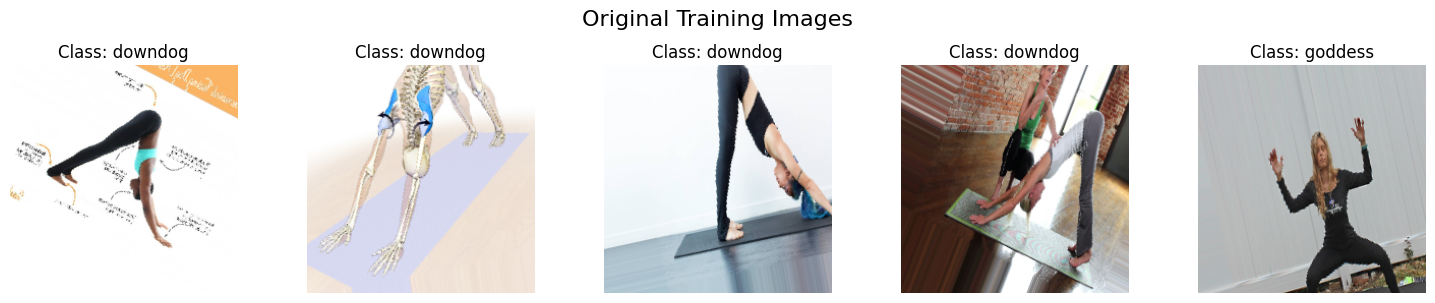

In [ ]:
def plot_sample_images(generator, title):
    """Plot a grid of sample images from the generator"""
    plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        batch = next(generator)
        image = batch[0][0]
        plt.imshow(image)
        plt.title(f'Class: {list(generator.class_indices.keys())[batch[1][0].argmax()]}')
        plt.axis('off')
    plt.suptitle(title, size=16)
    plt.tight_layout()
    plt.show()

# Visualize original training images
plot_sample_images(train_generator, 'Original Training Images')

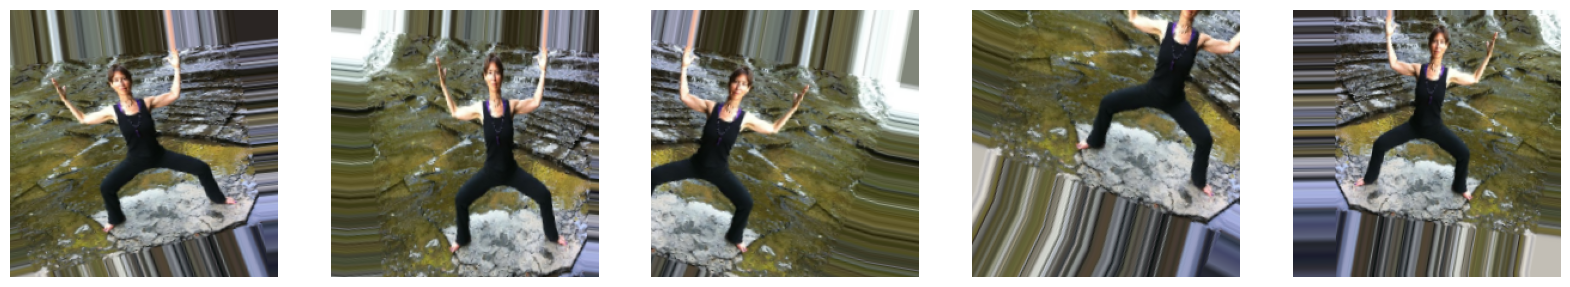

In [ ]:
# Create a new data generator with augmentation
aug_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load a single image
sample_image, _ = next(train_generator)
sample_image = sample_image[0]

# Generate augmented images
aug_generator = aug_datagen.flow(np.expand_dims(sample_image, axis=0), batch_size=1)

# Visualize augmented images
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    augmented_image = next(aug_generator)[0]
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.show()

## Model Architectures with Detailed Parameters

We'll implement three different architectures:
1. Simple CNN (from scratch)
2. Inception-style CNN (from scratch)
3. Transfer Learning with MobileNetV2 (pre-trained)

In [ ]:
def create_simple_cnn():
    """Create a simple CNN architecture with explicit parameters"""
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),
        layers.BatchNormalization(name='bn3'),

        # Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(2, activation='softmax', name='output')
    ])
    return model

def inception_module(x, filters, stage):
    """Create an inception module with named layers"""
    path1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu', name=f'inception_{stage}_1x1')(x)

    path2 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu', name=f'inception_{stage}_3x3_reduce')(x)
    path2 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu', name=f'inception_{stage}_3x3')(path2)

    path3 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu', name=f'inception_{stage}_5x5_reduce')(x)
    path3 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu', name=f'inception_{stage}_5x5')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same', name=f'inception_{stage}_pool')(x)
    path4 = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu', name=f'inception_{stage}_pool_proj')(path4)

    return layers.Concatenate(name=f'inception_{stage}_output')([path1, path2, path3, path4])

def create_inception_cnn():
    """Create an Inception-style CNN architecture with explicit parameters"""
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input')

    # Initial Convolution
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    # Inception Modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32], stage=1)
    x = inception_module(x, [128, 128, 192, 32, 96, 64], stage=2)

    # Output Layers
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(0.4, name='dropout')(x)
    outputs = layers.Dense(2, activation='softmax', name='output')(x)

    return models.Model(inputs, outputs)

def create_mobilenet_model():
    """Create a model using pre-trained MobileNetV2 with explicit parameters"""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='avg_pool'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dropout(0.2, name='dropout'),
        layers.Dense(2, activation='softmax', name='output')
    ])
    return model

In [ ]:
def train_model(model, model_name):
    """Train a model with explicit hyperparameters"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    print(f'\n{model_name} Architecture:')
    model.summary()

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'models/{model_name}_best.keras',
            monitor='val_accuracy',
            # monitor='accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            # monitor='loss',
            factor=0.2,
            patience=2,
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        epochs=MAX_EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
def evaluate_model(model, history, model_name):
    """Evaluate model performance with detailed visualizations"""
    # Training History Visualization
    plt.figure(figsize=(15, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
    plt.title(f'{model_name} - Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', marker='o')
    plt.plot(history.history['val_loss'], label='Validation', marker='o')
    plt.title(f'{model_name} - Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Test Set Evaluation
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    print(f'\n{model_name} Test Results:')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}')

    # Generate predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print(f'\n{model_name} Classification Report:')
    print(classification_report(y_true, y_pred,
                              target_names=test_generator.class_indices.keys()))

    # Sample Predictions Visualization
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        batch = next(test_generator)
        image = batch[0][0]
        true_label = list(test_generator.class_indices.keys())[batch[1][0].argmax()]
        pred_label = list(test_generator.class_indices.keys())[model.predict(batch[0][0:1]).argmax()]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        plt.axis('off')
    plt.suptitle(f'{model_name} - Sample Predictions', size=16)
    plt.tight_layout()
    plt.show()

## Train and Evaluate Models
### Model Comparison

Here's a comparison of the three architectures:

1. **Simple CNN**:
   - Pros: Simple, fast to train, good for basic feature learning
   - Cons: May not capture complex features, limited capacity

2. **Inception-style CNN**:
   - Pros: Better feature extraction, multi-scale processing, residual connections
   - Cons: More parameters, longer training time, may need more data

3. **Transfer Learning**:
   - Pros: Pre-trained features, robust, less data needed
   - Cons: Less specialized for yoga poses, larger model size

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 222, 222, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 109, 109, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 52, 52, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,132,738 (42.47 MB)

 Trainable params: 11,132,418 (42.47 MB)

 Non-trainable params: 320 (1.25 KB)


simple_cnn Architecture:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 222, 222, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 109, 109, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 52, 52, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,132,738 (42.47 MB)

 Trainable params: 11,132,418 (42.47 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5560 - loss: 14.9037
Epoch 1: val_accuracy improved from -inf to 0.55696, saving model to models/simple_cnn_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5539 - loss: 15.4306 - val_accuracy: 0.5570 - val_loss: 1.8384 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5928 - loss: 17.2112
Epoch 2: val_accuracy did not improve from 0.55696
11/11 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.5941 - loss: 17.5552 - val_accuracy: 0.4937 - val_loss: 1.4754 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5932 - loss: 23.5002
Epoch 3: val_accuracy did not improve from 0.55696
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.5924 - loss: 23.5743 - val_accuracy: 0.5570 - val_loss: 7.1870 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6137 - loss: 17.1876
Epoch 4: val_accuracy did not improve from 0.55696

Epo

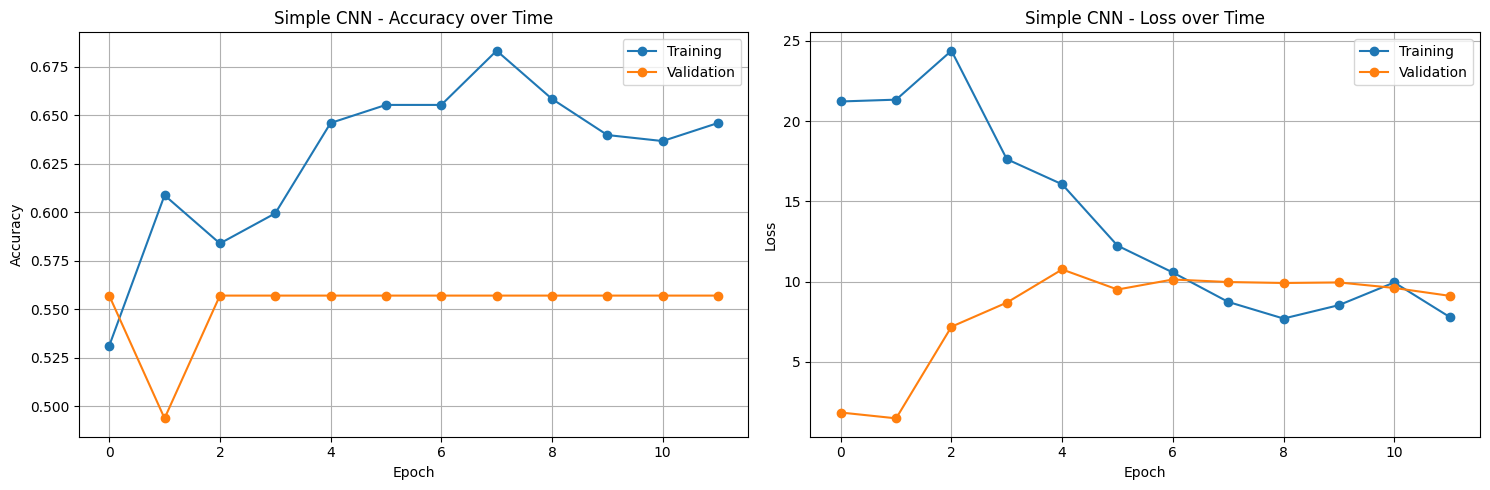

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3800 - loss: 1.6547

Simple CNN Test Results:
Test Accuracy: 0.3908
Test Loss: 1.7017
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


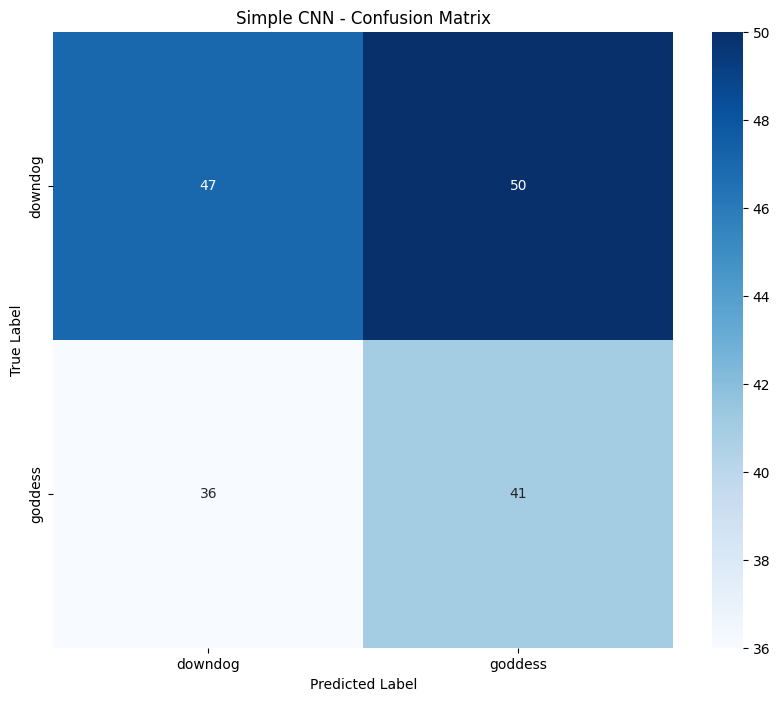


Simple CNN Classification Report:
              precision    recall  f1-score   support

     downdog       0.57      0.48      0.52        97
     goddess       0.45      0.53      0.49        77

    accuracy                           0.51       174
   macro avg       0.51      0.51      0.51       174
weighted avg       0.52      0.51      0.51       174

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


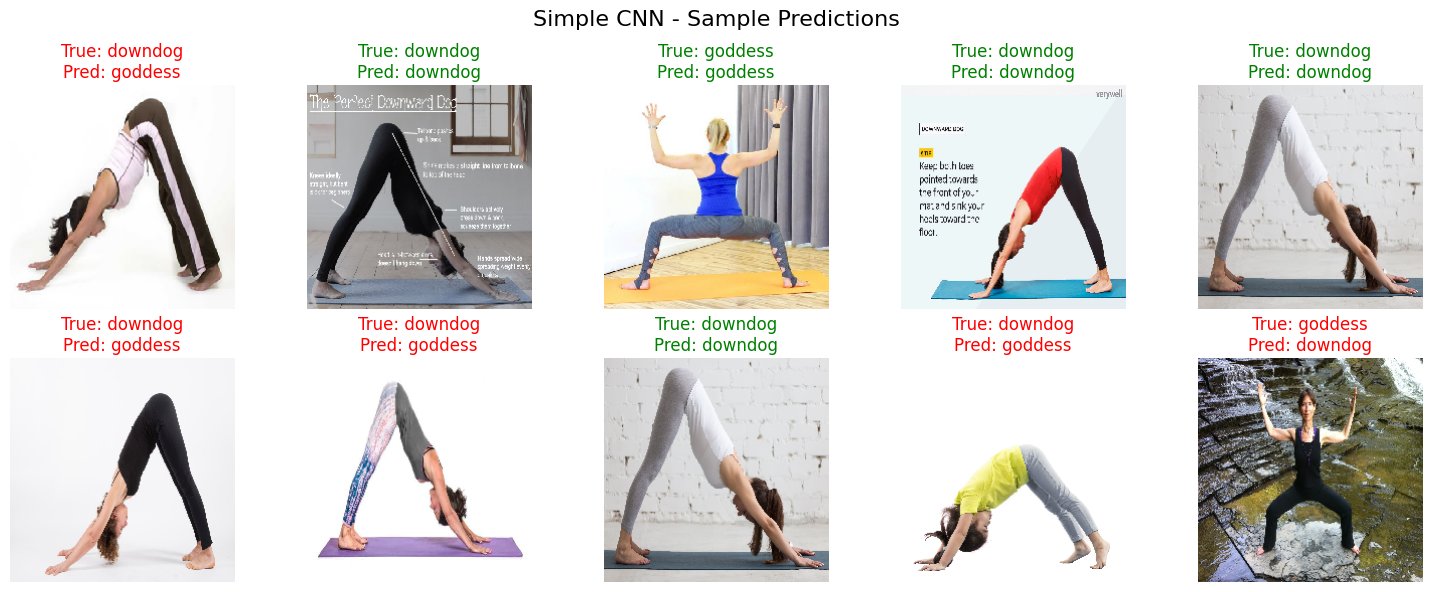

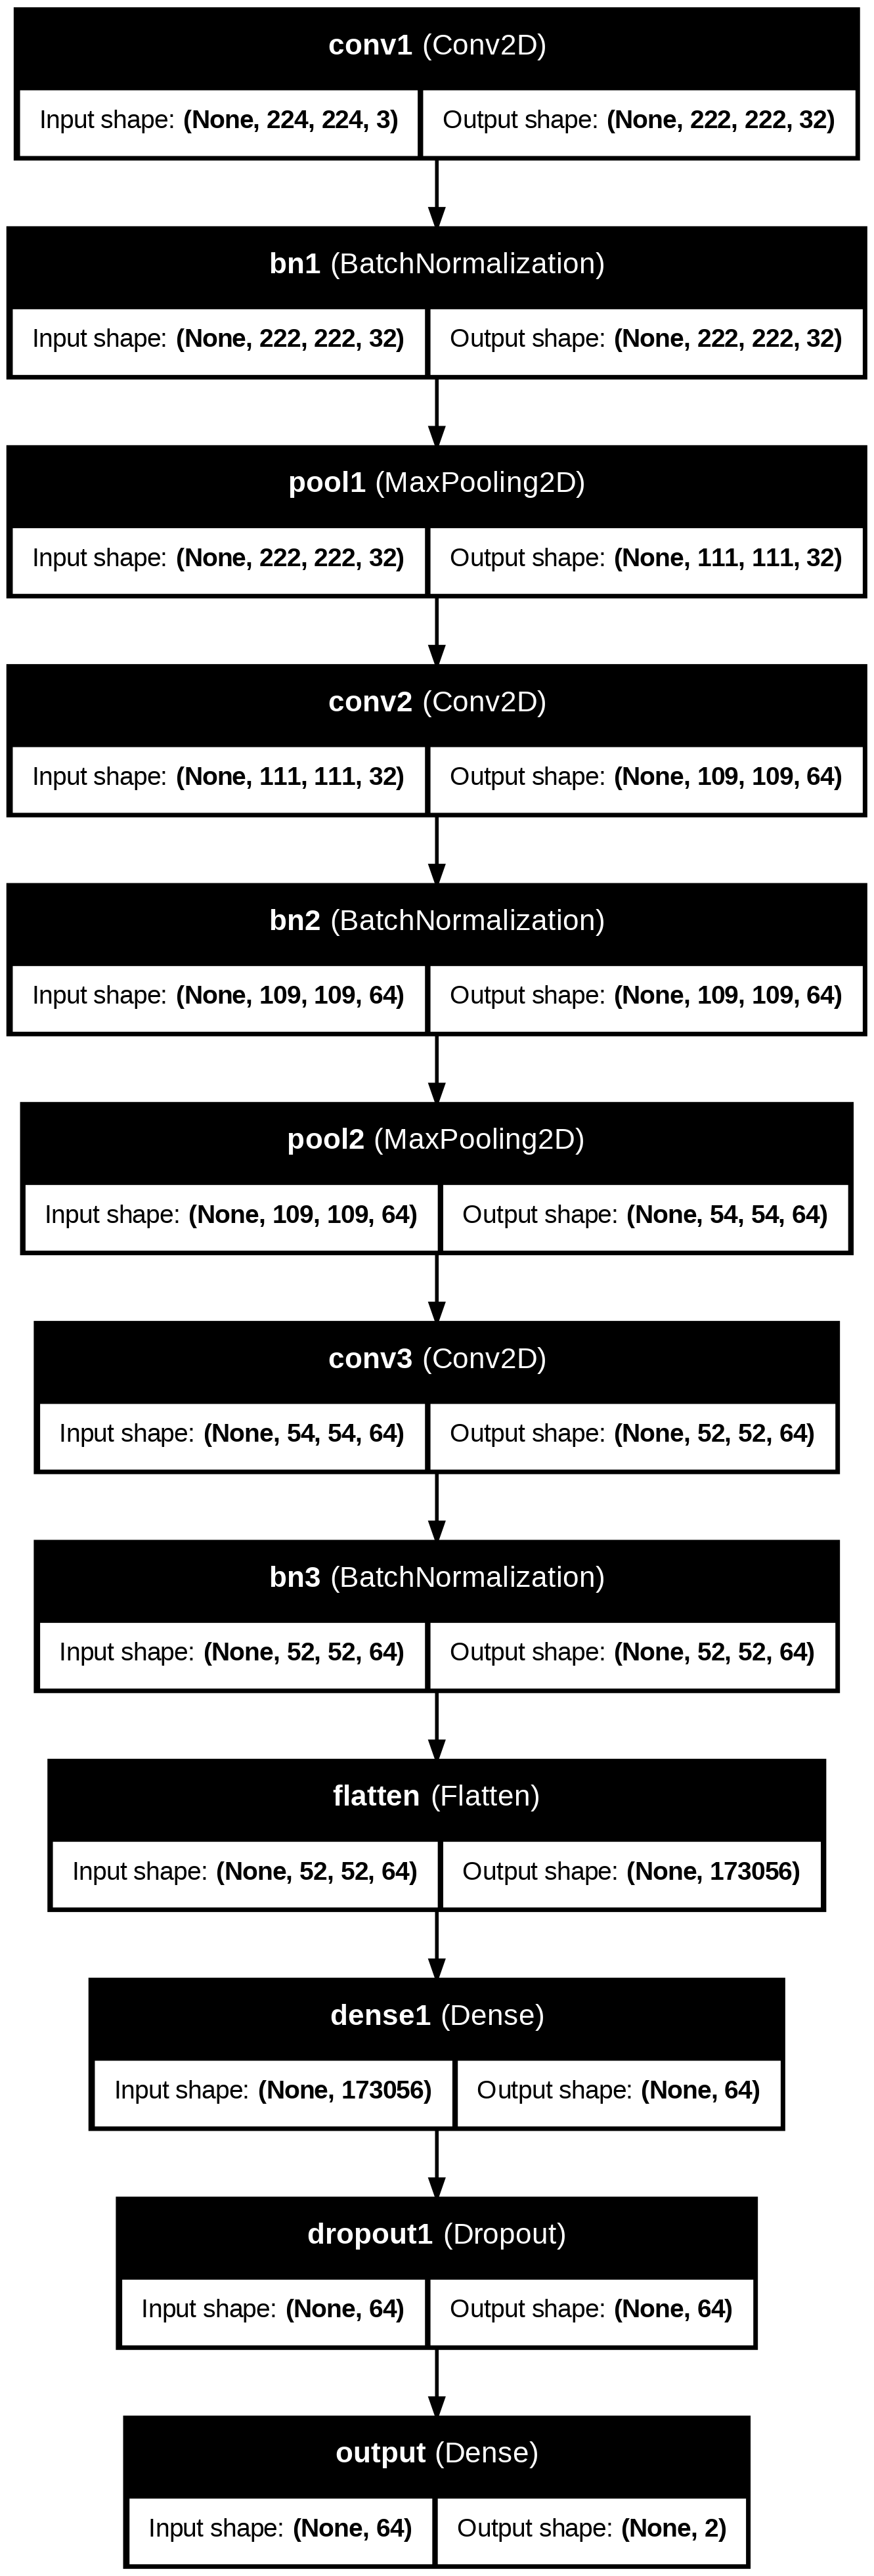

In [ ]:
# Train and evaluate Simple CNN
simple_cnn = create_simple_cnn()
simple_cnn.summary()
simple_history = train_model(simple_cnn, 'simple_cnn')
evaluate_model(simple_cnn, simple_history, 'Simple CNN')
utils.plot_model(simple_cnn, show_shapes=True, show_layer_names=True)


mobilenet Architecture:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,098 (8.93 MB)

 Trainable params: 82,114 (320.76 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5920 - loss: 0.6696
Epoch 1: val_accuracy improved from -inf to 0.94937, saving model to models/mobilenet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6014 - loss: 0.6574 - val_accuracy: 0.9494 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8909 - loss: 0.2663
Epoch 2: val_accuracy improved from 0.94937 to 0.96203, saving model to models/mobilenet_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8915 - loss: 0.2660 - val_accuracy: 0.9620 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9243 - loss: 0.2356
Epoch 3: val_accuracy did not improve from 0.96203
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9239 - loss: 0.2349 - val_accuracy: 0.9620 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9416 - loss: 0.1807
Epoch 4: val_a

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,504,328 (9.55 MB)

 Trainable params: 82,114 (320.76 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 164,230 (641.53 KB)

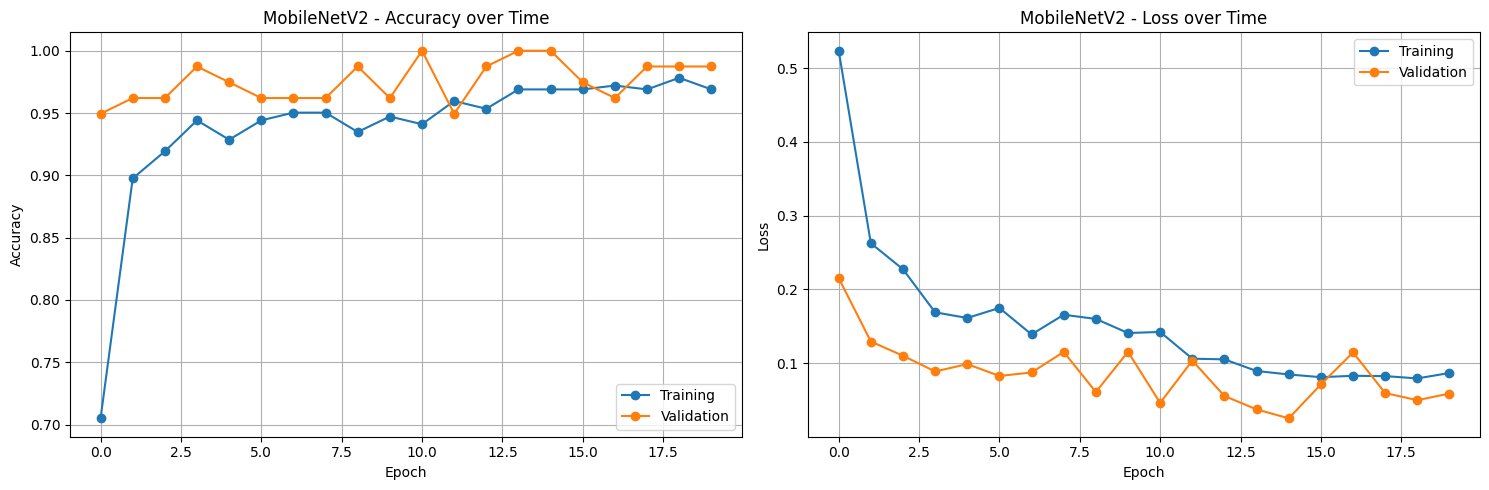

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9912 - loss: 0.0362

MobileNetV2 Test Results:
Test Accuracy: 0.9885
Test Loss: 0.0375
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


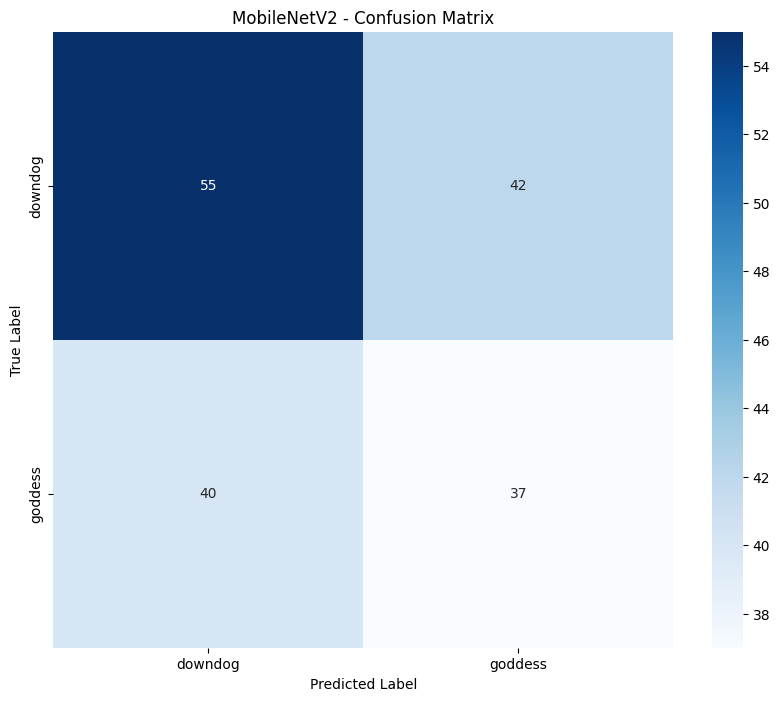


MobileNetV2 Classification Report:
              precision    recall  f1-score   support

     downdog       0.58      0.57      0.57        97
     goddess       0.47      0.48      0.47        77

    accuracy                           0.53       174
   macro avg       0.52      0.52      0.52       174
weighted avg       0.53      0.53      0.53       174

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


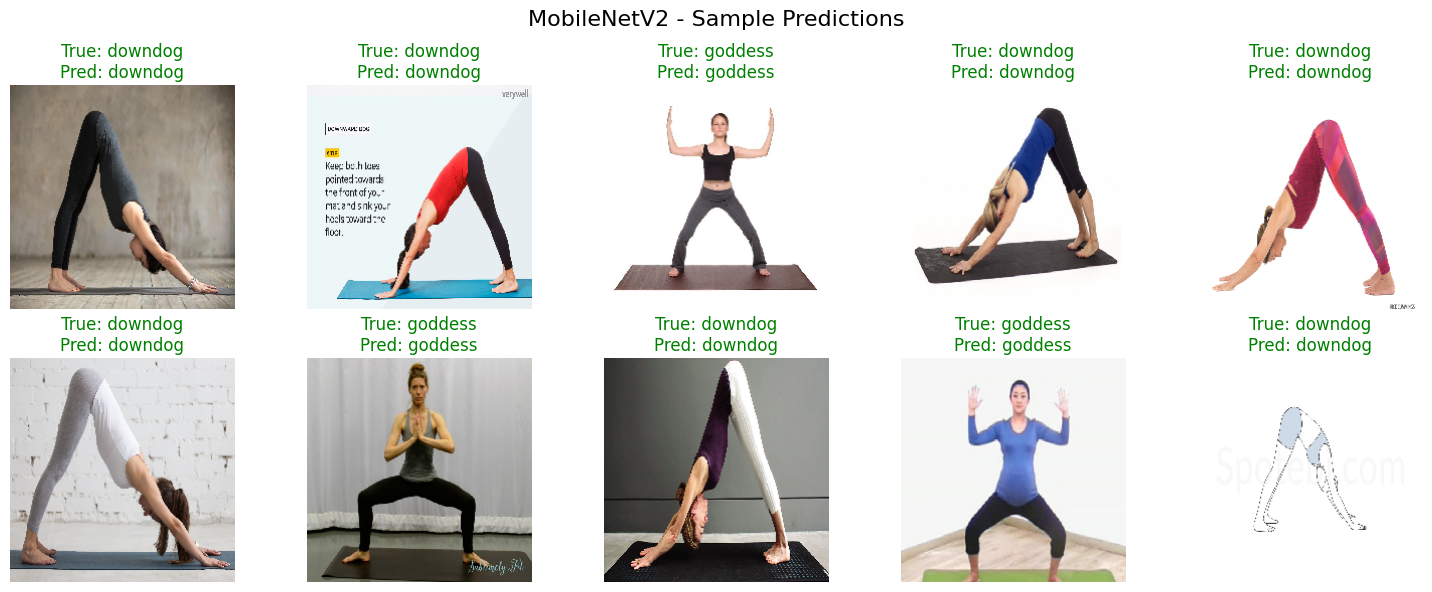

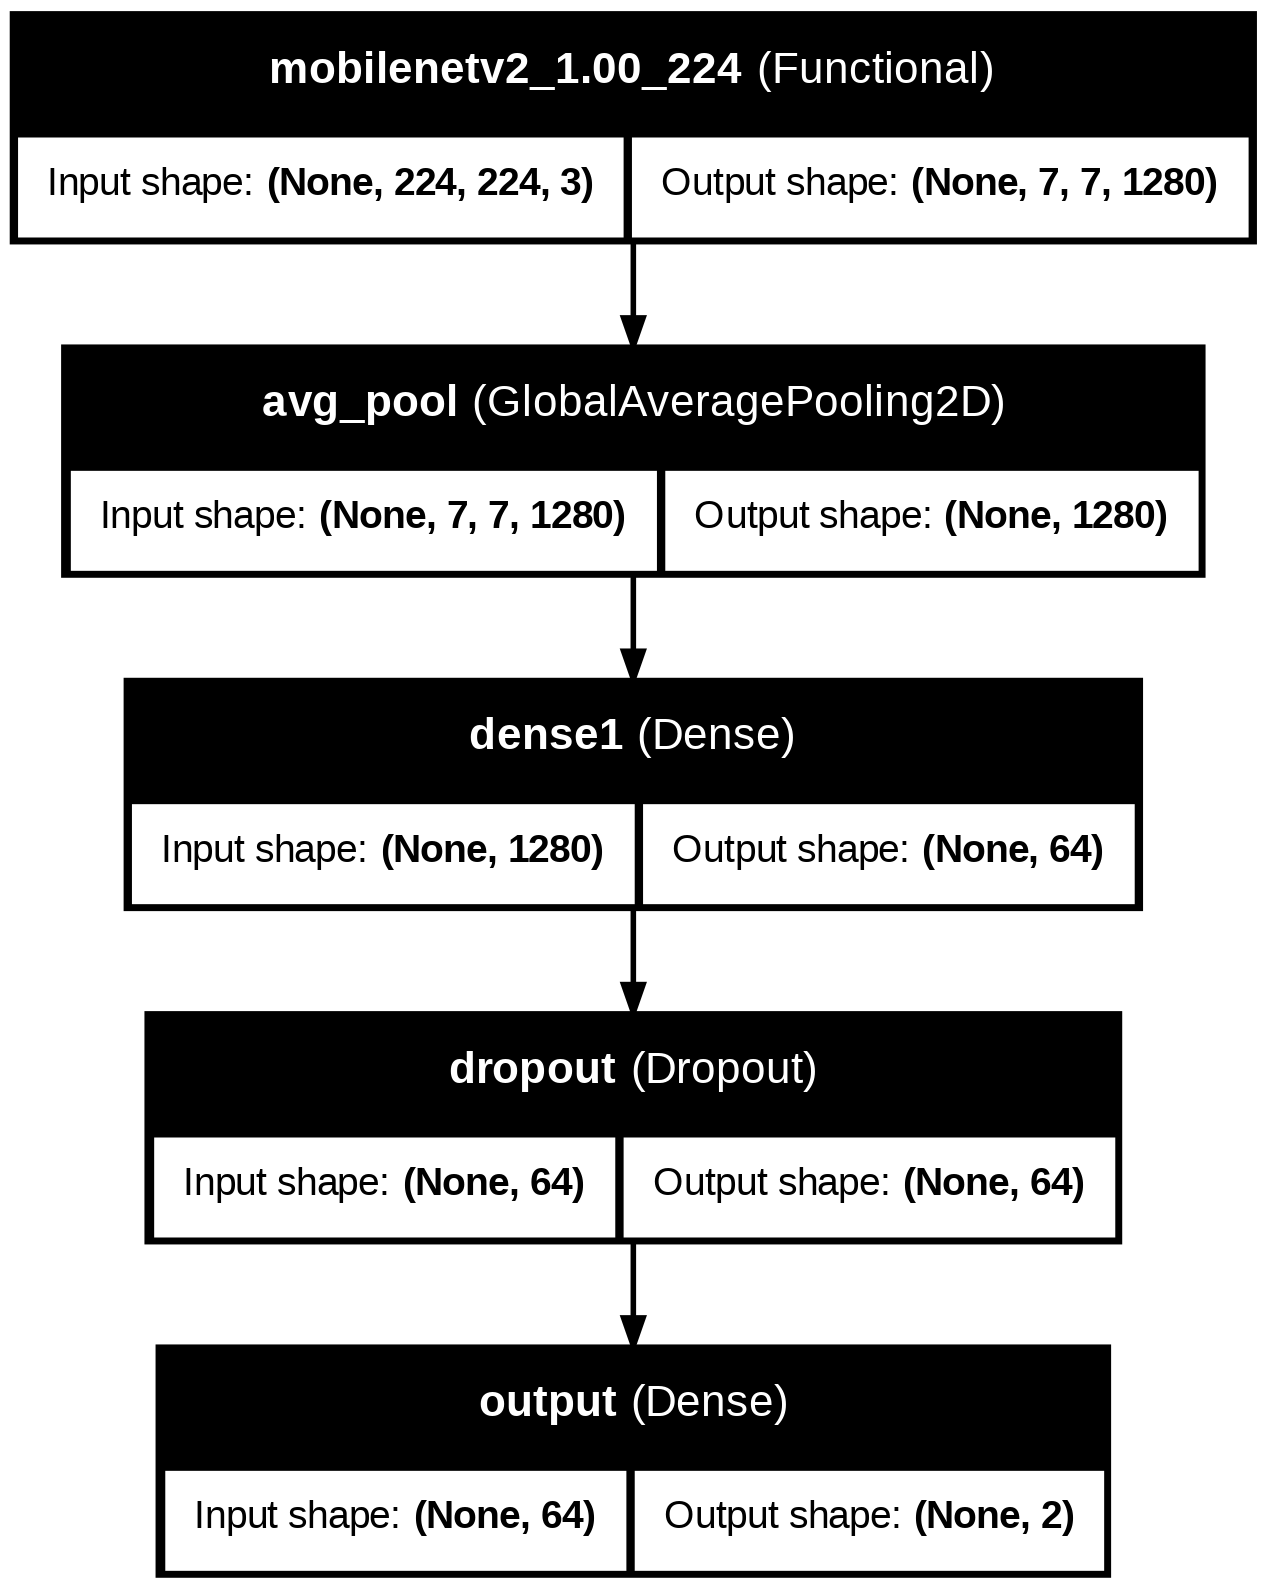

In [ ]:
# Train and evaluate MobileNetV2
mobilenet_model = create_mobilenet_model()
mobilenet_history = train_model(mobilenet_model, 'mobilenet')
mobilenet_model.summary()
evaluate_model(mobilenet_model, mobilenet_history, 'MobileNetV2')
utils.plot_model(mobilenet_model, show_shapes=True, show_layer_names=True)

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3_reduce    │ (None, 56, 56, 96)     │          6,240 │ pool1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5_reduce    │ (None, 56, 56, 16)     │          1,040 │ pool1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool          │ (None, 56, 56, 64)     │              0 │ pool1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_1x1 (Conv2D)  │ (None, 56, 56, 64)     │          4,160 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3 (Conv2D)  │ (None, 56, 56, 128)    │        110,720 │ inception_1_3x3_reduc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5 (Conv2D)  │ (None, 56, 56, 32)     │         12,832 │ inception_1_5x5_reduc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool_proj     │ (None, 56, 56, 32)     │          2,080 │ inception_1_pool[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_output        │ (None, 56, 56, 256)    │              0 │ inception_1_1x1[0][0], │
│ (Concatenate)             │                        │                │ inception_1_3x3[0][0], │
│                           │                        │                │ inception_1_5x5[0][0], │
│                           │                        │                │ inception_1_pool_proj… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_3x3_reduce    │ (None, 56, 56, 128)    │         32,896 │ inception_1_output[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_5x5_reduce    │ (None, 56, 56, 32)     │          8,224 │ inception_1_output[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_pool          │ (None, 56, 56, 256)    │              0 │ inception_1_output[0]… │
│ (MaxPooling2D)       

 Total params: 536,498 (2.05 MB)

 Trainable params: 536,370 (2.05 MB)

 Non-trainable params: 128 (512.00 B)


inception_cnn Architecture:


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3_reduce    │ (None, 56, 56, 96)     │          6,240 │ pool1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5_reduce    │ (None, 56, 56, 16)     │          1,040 │ pool1[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool          │ (None, 56, 56, 64)     │              0 │ pool1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_1x1 (Conv2D)  │ (None, 56, 56, 64)     │          4,160 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_3x3 (Conv2D)  │ (None, 56, 56, 128)    │        110,720 │ inception_1_3x3_reduc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_5x5 (Conv2D)  │ (None, 56, 56, 32)     │         12,832 │ inception_1_5x5_reduc… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_pool_proj     │ (None, 56, 56, 32)     │          2,080 │ inception_1_pool[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_1_output        │ (None, 56, 56, 256)    │              0 │ inception_1_1x1[0][0], │
│ (Concatenate)             │                        │                │ inception_1_3x3[0][0], │
│                           │                        │                │ inception_1_5x5[0][0], │
│                           │                        │                │ inception_1_pool_proj… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_3x3_reduce    │ (None, 56, 56, 128)    │         32,896 │ inception_1_output[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_5x5_reduce    │ (None, 56, 56, 32)     │          8,224 │ inception_1_output[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_2_pool          │ (None, 56, 56, 256)    │              0 │ inception_1_output[0]… │
│ (MaxPooling2D)       

 Total params: 536,498 (2.05 MB)

 Trainable params: 536,370 (2.05 MB)

 Non-trainable params: 128 (512.00 B)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5083 - loss: 1.0643 
Epoch 1: val_accuracy improved from -inf to 0.44304, saving model to models/inception_cnn_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 136s 11s/step - accuracy: 0.5089 - loss: 1.0514 - val_accuracy: 0.4430 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5614 - loss: 0.6921
Epoch 2: val_accuracy did not improve from 0.44304
11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 11s/step - accuracy: 0.5599 - loss: 0.6923 - val_accuracy: 0.4304 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5719 - loss: 0.6809
Epoch 3: val_accuracy improved from 0.44304 to 0.55696, saving model to models/inception_cnn_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 123s 11s/step - accuracy: 0.5708 - loss: 0.6814 - val_accuracy: 0.5570 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6301

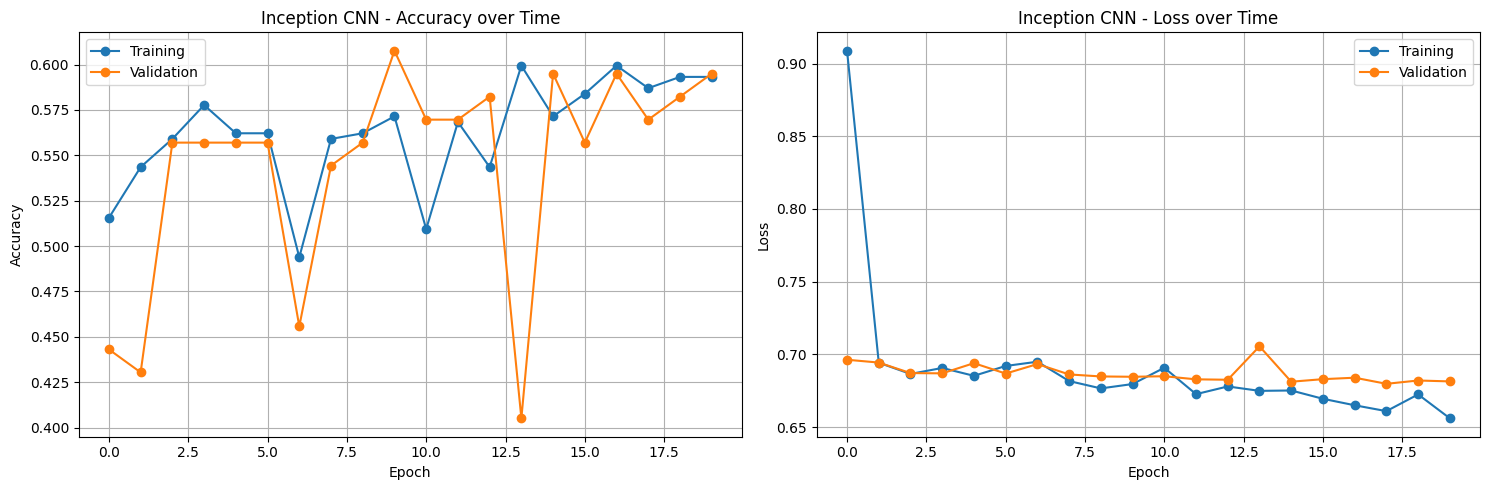

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5818 - loss: 0.6924

Inception CNN Test Results:
Test Accuracy: 0.5805
Test Loss: 0.6929
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


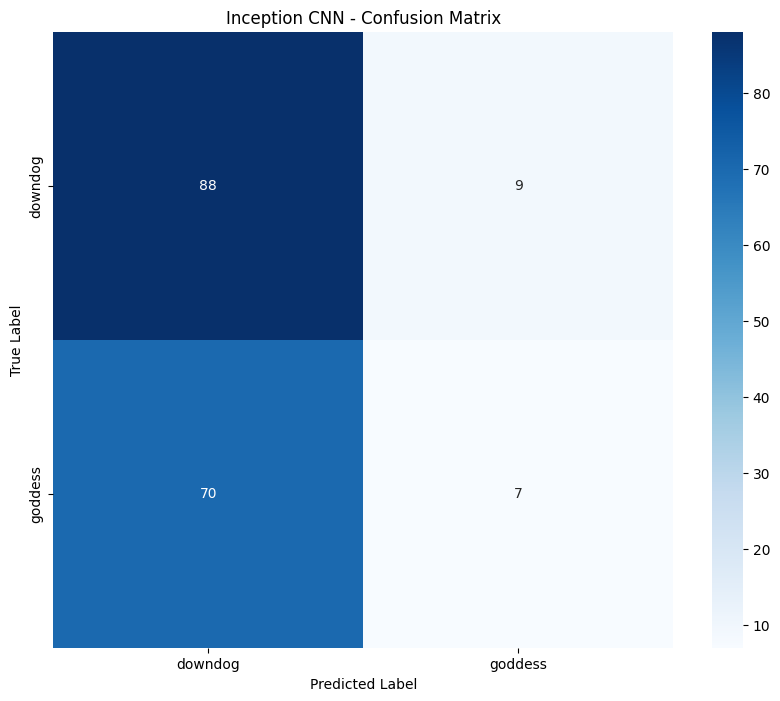


Inception CNN Classification Report:
              precision    recall  f1-score   support

     downdog       0.56      0.91      0.69        97
     goddess       0.44      0.09      0.15        77

    accuracy                           0.55       174
   macro avg       0.50      0.50      0.42       174
weighted avg       0.50      0.55      0.45       174

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


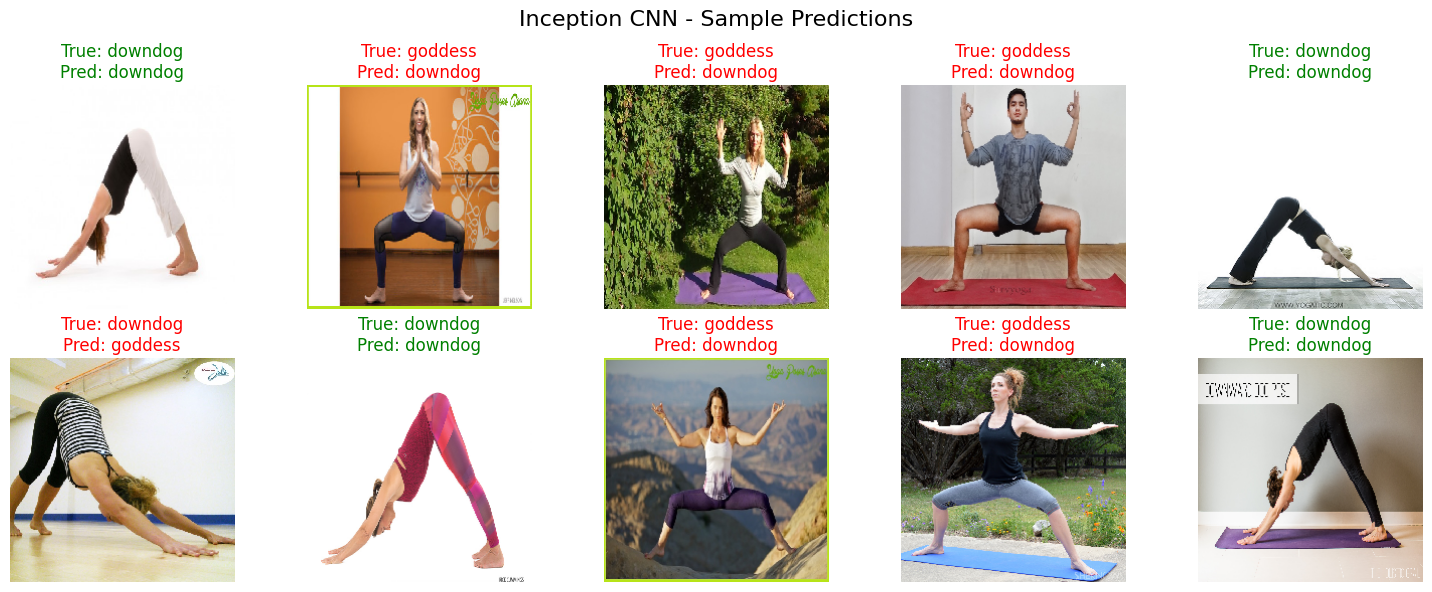

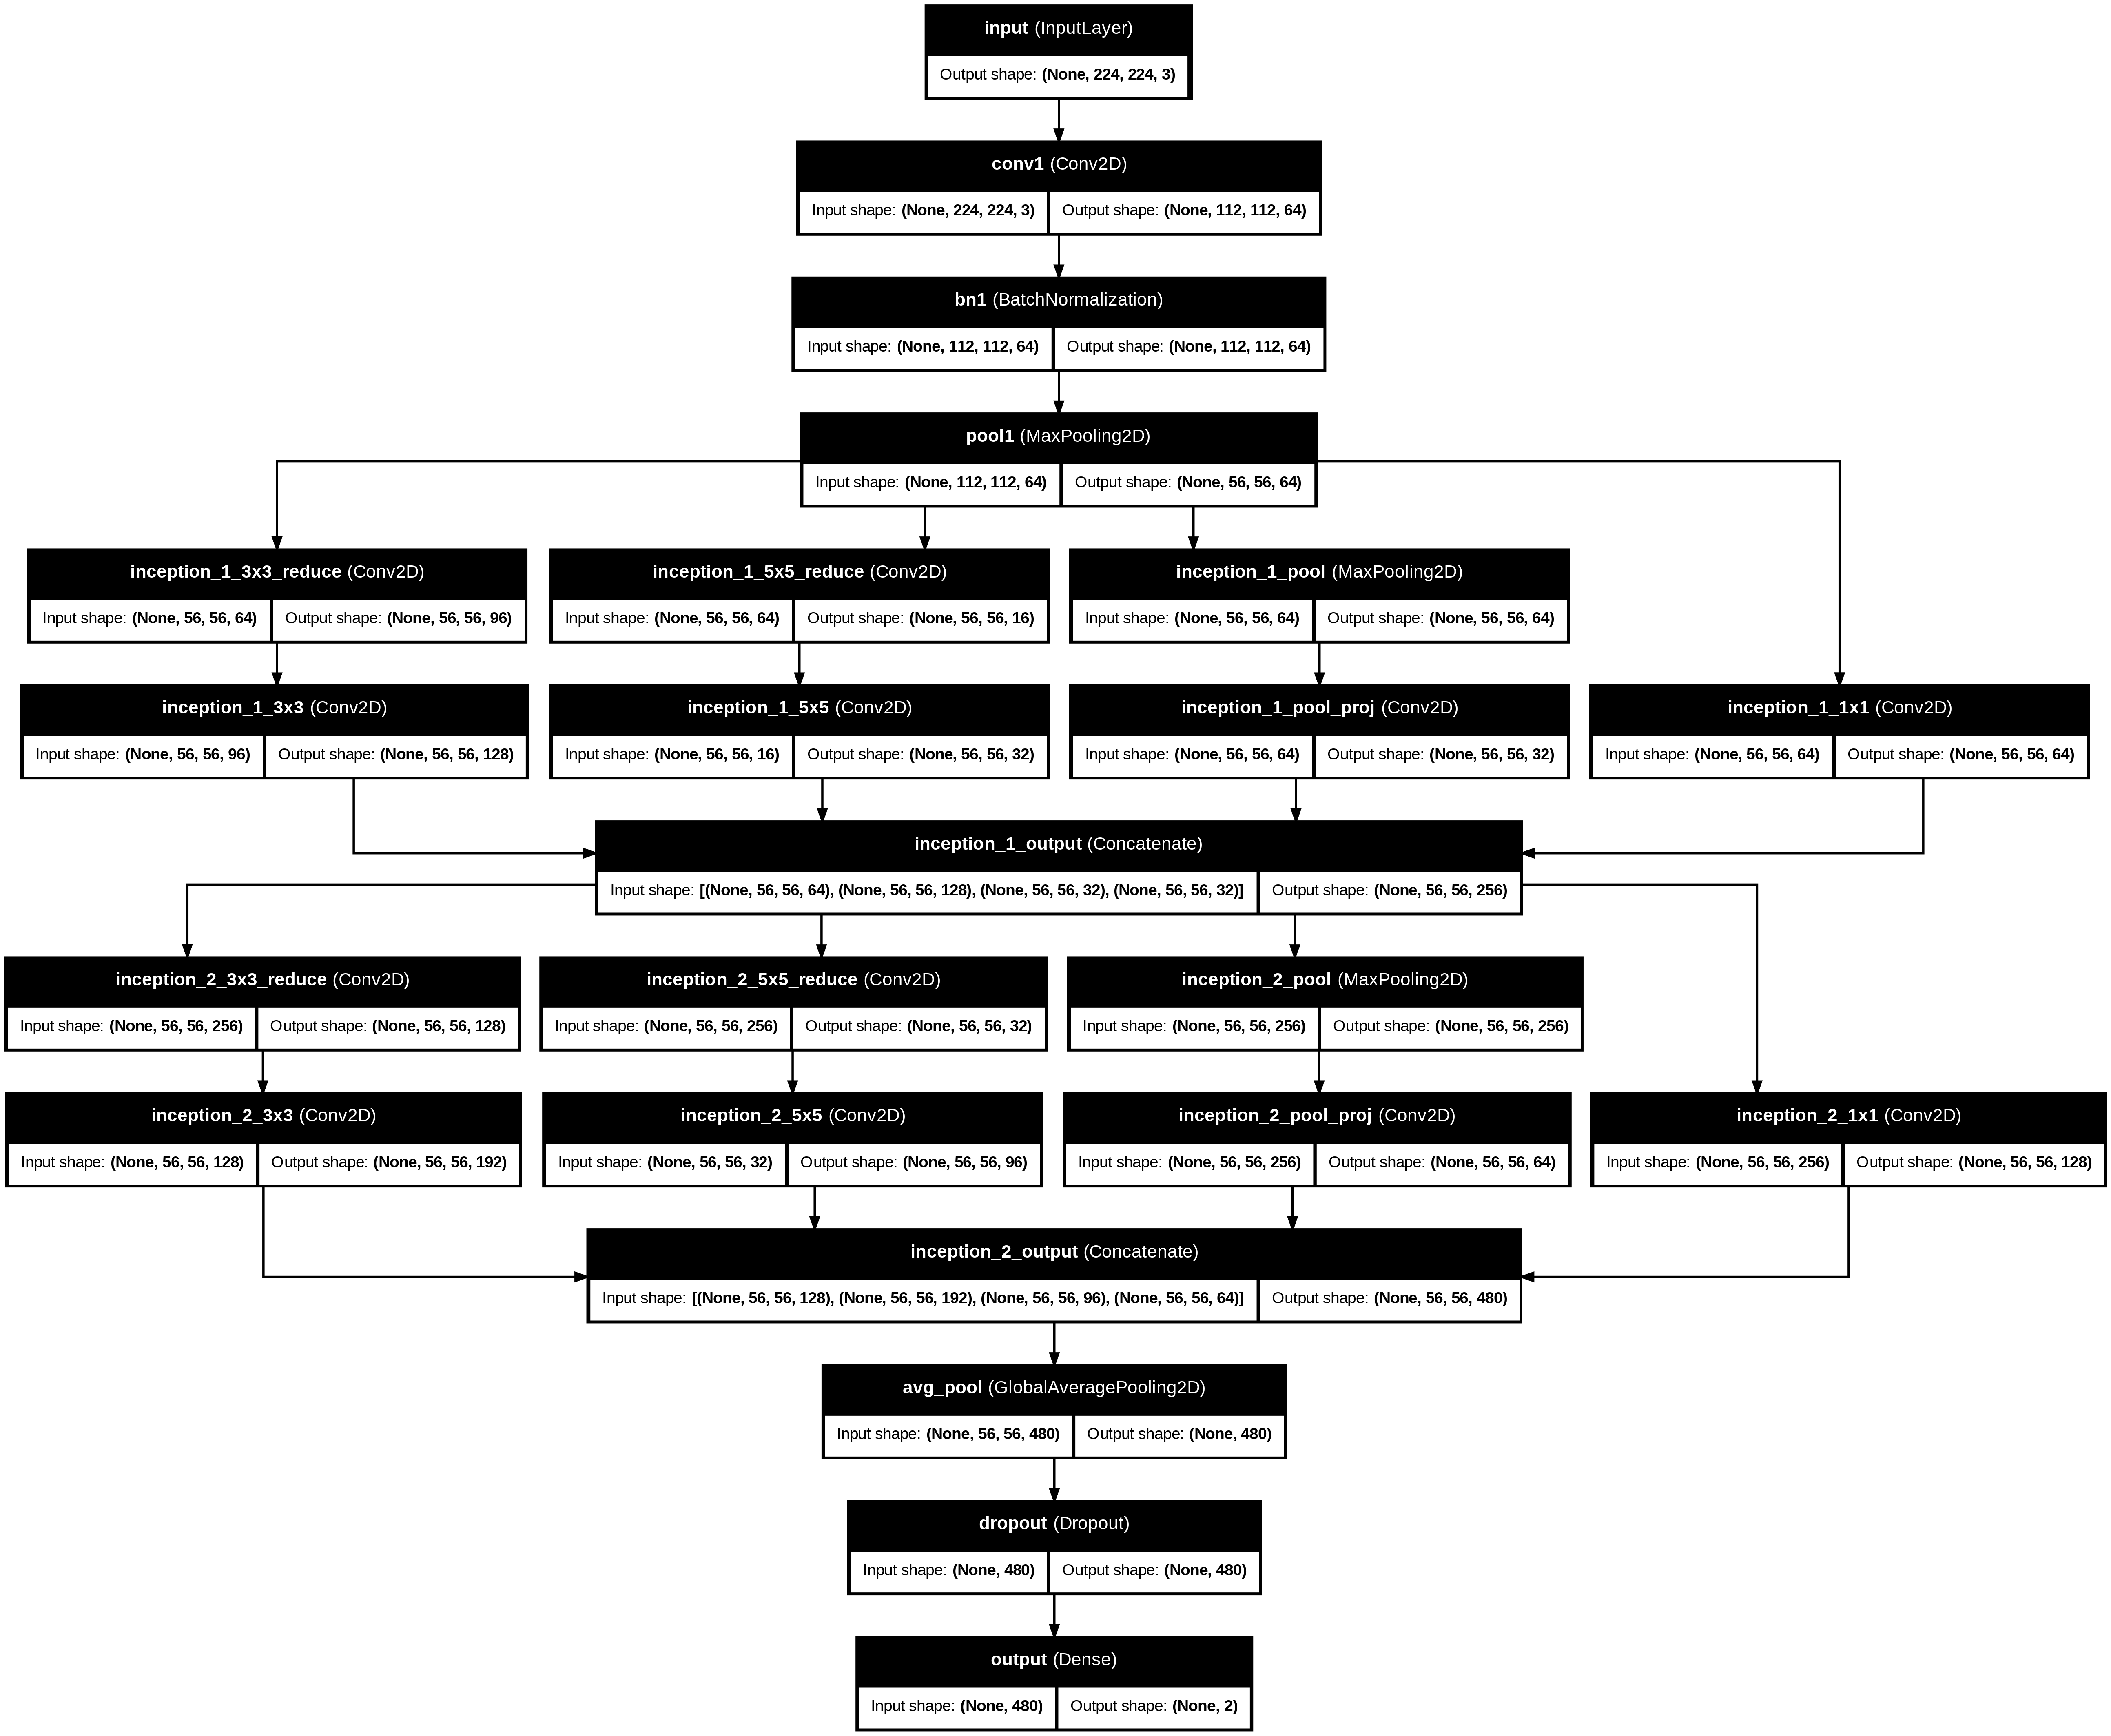

In [123]:
# Train and evaluate Inception-style CNN
inception_cnn = create_inception_cnn()
inception_cnn.summary()

inception_history = train_model(inception_cnn, 'inception_cnn')
evaluate_model(inception_cnn, inception_history, 'Inception CNN')
utils.plot_model(inception_cnn, show_shapes=True, show_layer_names=True)

## Model Comparison and Analysis

Let's compare the performance of all three models:

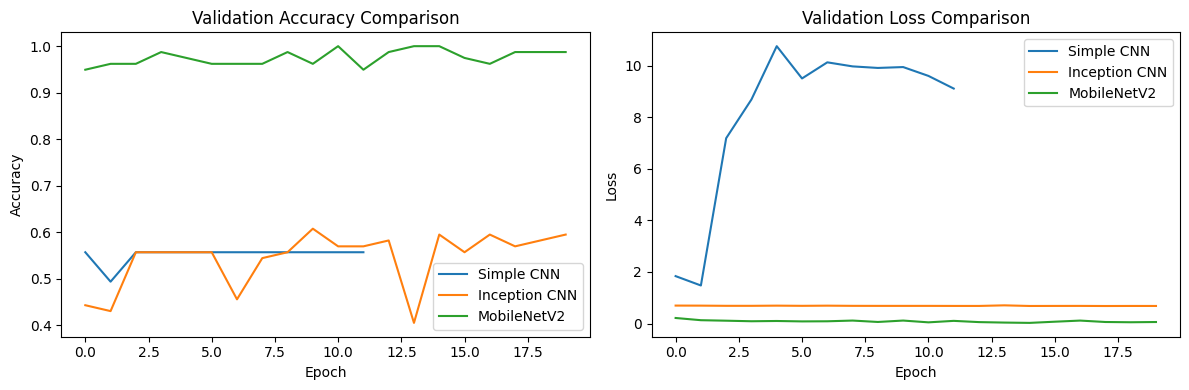

In [125]:
def compare_models(models_data):
    """Compare performance metrics across models"""
    # Plot validation accuracy comparison
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for name, history in models_data:
        plt.plot(history.history['val_accuracy'], label=name)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, history in models_data:
        plt.plot(history.history['val_loss'], label=name)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Compare all models
models_data = [
    ('Simple CNN', simple_history),
    ('Inception CNN', inception_history),
    ('MobileNetV2', mobilenet_history)
]

compare_models(models_data)

In [126]:
print("Model Parameter Comparison:")
print("-" * 50)
for name, history in models_data:
    model = history.model  # Get the model from the history object
    print(f"{name}: {model.count_params():,} parameters")

Model Parameter Comparison:
--------------------------------------------------
Simple CNN: 11,132,738 parameters
Inception CNN: 536,498 parameters
MobileNetV2: 2,340,098 parameters


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Simple CNN Prediction: goddess, Probability: [[0.40192977 0.5980702 ]]
Inception CNN Prediction: downdog, Probability: [[0.50551665 0.49448338]]
MobileNetV2 Prediction: goddess, Probability: [[8.7041635e-04 9.9912959e-01]]


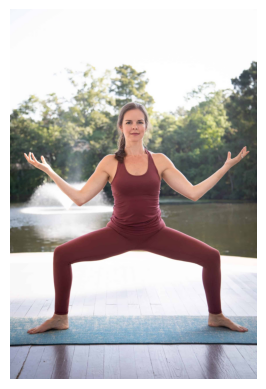

In [130]:
# prompt: how to test the 3 models with real images that i upload

import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load your trained models
simple_cnn = tf.keras.models.load_model('models/simple_cnn_best.keras')
inception_cnn = tf.keras.models.load_model('models/inception_cnn_best.keras')
mobilenet_model = tf.keras.models.load_model('models/mobilenet_best.keras')

# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # Important: Use MobileNetV2's preprocessing
    return x

# Function to predict the class
def predict_class(model, img_path, class_indices):
    processed_image = preprocess_image(img_path)
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[predicted_class_index]
    return predicted_class, prediction

# Get the class indices (you might need to adjust this based on your data generator)
class_indices = train_generator.class_indices

# Example usage:
# uploaded_image_path = '/content/yoga-poses.jpg' # Replace with actual path
uploaded_image_path = '/content/Nicole_202-Pose-scaled.jpg' # Replace with actual path


# Make predictions with all three models
simple_cnn_prediction, simple_cnn_prob = predict_class(simple_cnn, uploaded_image_path, class_indices)
inception_cnn_prediction, inception_cnn_prob = predict_class(inception_cnn, uploaded_image_path, class_indices)
mobilenet_prediction, mobilenet_prob = predict_class(mobilenet_model, uploaded_image_path, class_indices)

print(f"Simple CNN Prediction: {simple_cnn_prediction}, Probability: {simple_cnn_prob}")
print(f"Inception CNN Prediction: {inception_cnn_prediction}, Probability: {inception_cnn_prob}")
print(f"MobileNetV2 Prediction: {mobilenet_prediction}, Probability: {mobilenet_prob}")

# Display the image
from PIL import Image
img = Image.open(uploaded_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [129]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import tensorflow as tf
import numpy as np

def create_upload_widget():
    # Create upload widget
    upload_widget = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Image'
    )

    # Create output widget for displaying results
    output_widget = widgets.Output()

    def on_upload_change(change):
        with output_widget:
            clear_output()
            if change['new']:
                # Get the uploaded file
                uploaded_file = next(iter(change['new'].values()))
                content = uploaded_file['content']

                # Convert to PIL Image
                image = Image.open(io.BytesIO(content))
                display(image)  # Show the uploaded image

                # Resize image to match model input size
                image = image.resize((224, 224))  # Adjust size to match your model's input size

                # Convert to array and preprocess
                img_array = tf.keras.preprocessing.image.img_to_array(image)
                img_array = tf.expand_dims(img_array, 0)
                img_array = img_array / 255.0  # Normalize

                # Make predictions with all three models
                print("\nPredictions from all models:")
                print("-" * 50)

                # Model 1 (CNN from scratch)
                predictions1 = simple_cnn.predict(img_array)
                predicted_class1 = list(test_generator.class_indices.keys())[predictions1.argmax()]
                confidence1 = float(predictions1.max())
                print(f"Model 1 (CNN from scratch):")
                print(f"Predicted Pose: {predicted_class1}")
                print(f"Confidence: {confidence1:.2%}")
                print("-" * 30)

                # Model 2 (Second architecture from scratch)
                predictions2 = inception_cnn.predict(img_array)
                predicted_class2 = list(test_generator.class_indices.keys())[predictions2.argmax()]
                confidence2 = float(predictions2.max())
                print(f"Model 2 (Second architecture):")
                print(f"Predicted Pose: {predicted_class2}")
                print(f"Confidence: {confidence2:.2%}")
                print("-" * 30)

                # Model 3 (Pre-trained model)
                predictions3 = mobilenet_model.predict(img_array)
                predicted_class3 = list(test_generator.class_indices.keys())[predictions3.argmax()]
                confidence3 = float(predictions3.max())
                print(f"Model 3 (Pre-trained):")
                print(f"Predicted Pose: {predicted_class3}")
                print(f"Confidence: {confidence3:.2%}")
                print("-" * 50)

                # Ensemble prediction (majority voting)
                predictions = [predicted_class1, predicted_class2, predicted_class3]
                confidences = [confidence1, confidence2, confidence3]

                from collections import Counter
                ensemble_pred = Counter(predictions).most_common(1)[0][0]

                # Get average confidence for the ensemble prediction
                avg_confidence = np.mean([conf for pred, conf in zip(predictions, confidences) if pred == ensemble_pred])

                print("\nEnsemble Prediction (Majority Voting):")
                print(f"Final Predicted Pose: {ensemble_pred}")
                print(f"Average Confidence: {avg_confidence:.2%}")

    # Attach the callback to the upload widget
    upload_widget.observe(on_upload_change, names='value')

    # Display both widgets
    display(upload_widget)
    display(output_widget)

# Create and display the upload widget
create_upload_widget()

FileUpload(value={}, accept='image/*', description='Upload Image')

Output()

## 5. Analysis and Conclusions

Let's analyze the performance of each model:

1. **Simple CNN**:
   - Training speed and resource usage
   - Accuracy vs complexity trade-off
   - Potential overfitting/underfitting

2. **Inception-style CNN**:
   - Impact of multi-scale feature extraction
   - Training stability
   - Model complexity vs performance gain

3. **Transfer Learning**:
   - Effectiveness of pre-trained features
   - Training time vs performance
   - Generalization ability

### Recommendations:
Based on the results, we can recommend the best model for this specific task considering:
- Accuracy requirements
- Training time constraints
- Resource limitations
- Deployment considerations